In [1]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install imgaug

In [3]:
# import os
# import numpy as np
# import imgaug.augmenters as iaa
# from PIL import Image

# # Input and output directories
# input_dir = "/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/positive"
# output_dir = "/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/positive"

# # List of available augmentation techniques
# augmentation_techniques = [
#     iaa.GaussianBlur(sigma=(0.0, 3.0)),
#     iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255)),
#     iaa.Affine(rotate=(-15, 15)),
#     # iaa.Fliplr(0.5),
#     iaa.Multiply((0.5, 1.5)),
#     iaa.ContrastNormalization((0.5, 2.0)),
#     iaa.Sometimes(0.8, iaa.Crop(percent=(0, 0.1))),
#     iaa.Sometimes(0.8, iaa.PerspectiveTransform(scale=(0.01, 0.1))),
#     iaa.Sometimes(0.8, iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25))
# ]

# # List of image filenames in the input directory
# image_filenames = [filename for filename in os.listdir(input_dir) if filename.lower().endswith(('.jpg', '.png', '.jpeg'))]

# # each image has only one augmentation
# # # Apply augmentations to each image
# # for image_filename in image_filenames:
# #     image_path = os.path.join(input_dir, image_filename)
# #     img = Image.open(image_path)

# #     # Randomly select an augmentation technique
# #     chosen_augmentation = np.random.choice(augmentation_techniques)

# #     # Apply the chosen augmentation
# #     augmented_img = chosen_augmentation.augment_image(np.array(img))

# #     # Save the augmented image with the specified naming convention
# #     output_filename = os.path.splitext(image_filename)[0] + "_augmented" + os.path.splitext(image_filename)[1]
# #     output_path = os.path.join(output_dir, output_filename)

# #     Image.fromarray(augmented_img).save(output_path)
# #     print(f"Augmented image saved: {output_path}")


# # each image has exactly three augmentations
# for image_filename in os.listdir(input_dir):
#     if image_filename.lower().endswith(('.jpg', '.png', '.jpeg')):
#         image_path = os.path.join(input_dir, image_filename)
#         img = Image.open(image_path)

#         # Apply three augmentations to each image
#         for i in range(3):
#             seq = iaa.Sequential(augmentation_techniques, random_order=True)
#             augmented_image = seq.augment_image(np.array(img))
#             output_filename = f"{os.path.splitext(image_filename)[0]}_augmented_{i+1}.jpg"
#             output_path = os.path.join(output_dir, output_filename)
#             Image.fromarray(augmented_image).save(output_path)
#             print(f"Augmented image saved: {output_path}")


In [4]:
!pip install tensorflow #==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [5]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.models import Model # used as ---> Model(inputs=[inputimg , compareimg] , outputs=[1,0]# same or not)
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [7]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [8]:
anc_path="/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/anchor"
pos_path="/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/positive"
neg_path="/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/negative"

In [9]:
len(os.listdir(neg_path))

60

In [10]:
anchor=tf.data.Dataset.list_files(anc_path+'/*.jpg').take(60)
positive=tf.data.Dataset.list_files(pos_path+'/*.jpg').take(60)
negative=tf.data.Dataset.list_files(neg_path+'/*.jpg').take(60)

In [11]:
dir_testing=anchor.as_numpy_iterator()

In [12]:
dir_testing.next()

b'/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/anchor/3 FURZER STREET PRESTON23_metadata_crop_001_logo_augmented_3.jpg'

In [13]:
def preprocess(img_path):
  byte_img=tf.io.read_file(img_path)
  img=tf.io.decode_jpeg(byte_img)
  img=tf.image.resize(img,(105,105))
  img=img/255.0
  return img

In [14]:
img=preprocess('/content/gdrive/MyDrive/Sequus/siamesenn/train_logo/anchor/3 FURZER STREET PRESTON22_metadata_crop_001_logo.jpg')

In [15]:
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.55145735, 0.55145735, 0.55145735],
        [0.5406258 , 0.5406258 , 0.5406258 ],
        [0.53029203, 0.53029203, 0.53029203],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.01302281, 0.01302281, 0.01302281],
        [0.00644738, 0.00644738, 0.00644738],
        [0.00509003, 0.00509003, 0.00509003],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.02608243, 0.02608243, 0.02608243],
        [0.00845138, 0.00845138, 0.00845138],
        [0.01056424, 0.01056424, 0.01056424],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.  

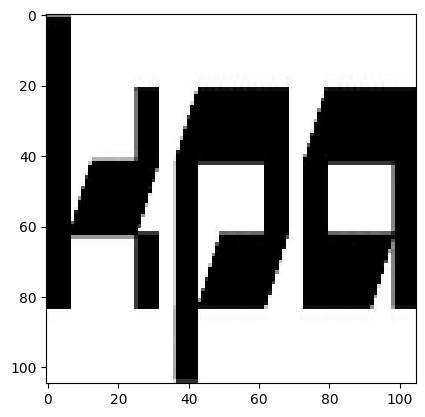

In [16]:
plt.imshow(img)

In [17]:
# (anc , pos)=> 1,1,1,1,1,1....,n
# (anc , neg)=> 0,0,0,0,0,0....,n

In [18]:
positives=tf.data.Dataset.zip((anchor , positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

In [19]:
negatives=tf.data.Dataset.zip((anchor , negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [20]:
data=positives.concatenate(negatives)

In [21]:
datacopy=data
datacopy.shuffle

<bound method DatasetV2.shuffle of <_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>>

In [22]:
samples = datacopy.as_numpy_iterator()

In [23]:
example=samples.next()

In [24]:
def preprocess_twins(input_img,given_img,label):
  return ( preprocess(input_img),preprocess(given_img) ,label)


In [25]:
result=preprocess_twins(*example)

In [26]:
len(result)

3

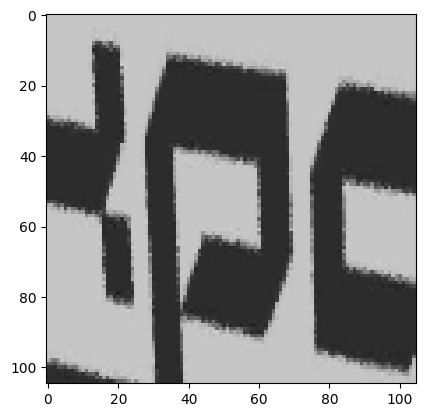

In [27]:
plt.imshow(result[0])

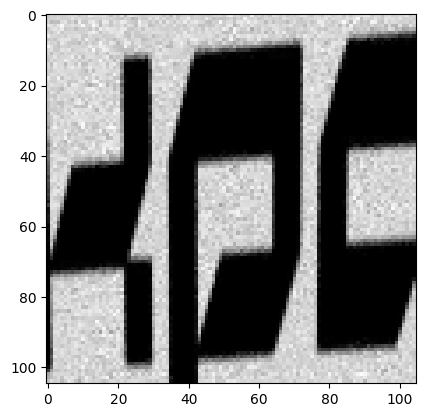

In [28]:
plt.imshow(result[1])

In [29]:
result[2]

1.0

In [41]:
data=data.map(preprocess_twins)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [42]:
# data=data.shuffle(buffer_size=1024)

In [43]:
sample=data.as_numpy_iterator()

In [44]:
example=sample.next()

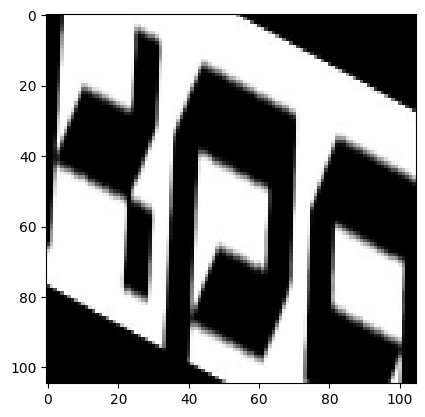

In [45]:
plt.imshow(example[0])

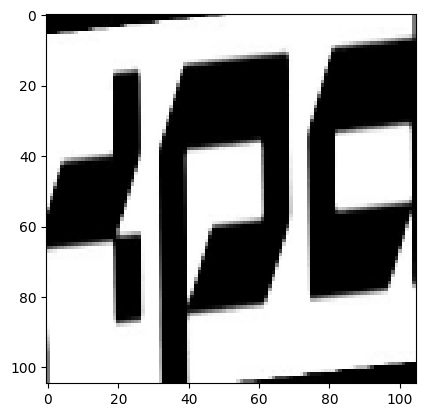

In [60]:
plt.imshow(example[1])

In [47]:
example[2]

1.0

In [48]:
round(len(data)*0.7)

84

In [49]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(8)
train_data=train_data.prefetch(6)

In [50]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [51]:
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(8)
test_data=test_data.prefetch(6)

In [52]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

model embeddeding layer

In [53]:
inp=Input(shape=(105,105,3), name='input_image')

In [54]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [55]:
c1=Conv2D(64,(10,10),activation='relu')(inp)

In [56]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [57]:
m1=MaxPooling2D(64,(2,2),padding='same')(c1)
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [58]:
c2=Conv2D(128,(7,7),activation='relu')(m1)
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_1')>

In [59]:
m2=MaxPooling2D(64,(2,2),padding='same')(c2)
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [62]:
  c3=Conv2D(128,(4,4),activation='relu')(m2)
  c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_2')>

In [63]:
m3=MaxPooling2D(64,(2,2),padding='same')(c3)
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [64]:
c4=Conv2D(256,(4,4),activation='relu')(m3)
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [65]:
f1=Flatten()(c4)
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [66]:
d1=Dense(4096,activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [70]:
mod= Model(inputs=[inp] , outputs=[d1] , name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [77]:
def make_embeddeding():
  inp=Input(shape=(105,105,3), name='input_image')

  # First Block
  c1=Conv2D(64,(10,10),activation='relu')(inp)
  m1=MaxPooling2D(64,(2,2),padding='same')(c1)

  # Second Block
  c2=Conv2D(128,(7,7),activation='relu')(m1)
  m2=MaxPooling2D(64,(2,2),padding='same')(c2)

  # Third Block
  c3=Conv2D(128,(4,4),activation='relu')(m2)
  m3=MaxPooling2D(64,(2,2),padding='same')(c3)

  # Final Embedding Block
  c4=Conv2D(256,(4,4),activation='relu')(m3)
  f1=Flatten()(c4)
  d1=Dense(4096,activation='sigmoid')(f1)




  return Model(inputs=[inp] , outputs=[d1] , name='embedding')

In [78]:
embedding=make_embeddeding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [71]:
# Build Custom L1 distance Layer
class L1Dist(Layer):
  def __init__(self,**kwargs):
    super().__init__()

  def call(self, input_embeddeding , validation_embeddeding):
    return tf.math.abs(input_embeddeding-validation_embeddeding)


In [79]:
l1=L1Dist()

In [80]:
input_image=Input(name='input_img',shape=(105,105,3))

validation_image=Input(name='validation_img',shape=(105,105,3))

input_embedding=embedding(input_image)
validation_embedding=embedding(validation_image)

In [81]:
l1(input_embedding,validation_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [82]:
def make_siamese_model():
  # Anchor input
  input_image=Input(name='input_img',shape=(105,105,3))

  # validation input
  validation_image=Input(name='validation_img',shape=(105,105,3))

  # combine embedding layer and L1 distance layer
  siamese_layer=L1Dist()
  siamese_layer._name='distance'
  distances=siamese_layer(embedding(input_image),embedding(validation_image))

  # classifier
  classifier=Dense(1,activation='sigmoid')(distances)

  return Model(inputs=[input_image,validation_image],outputs=classifier,name='Siamese_Neural_Network_ammar')

In [85]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "Siamese_Neural_Network_ammar"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'vali

In [86]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [87]:
optimizer=tf.keras.optimizers.Adam(1e-4)

In [88]:
checkpoint_dir="/content/gdrive/MyDrive/Sequus/siamesenn/checkpoints"
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(optimizer=optimizer,siamese_model=siamese_model)

In [89]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [92]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{epoch}')
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [93]:
EPOCHS = 20

In [94]:
train(train_data, EPOCHS)


 Epoch 1/1
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
11/11 [==============================] - 17s 191ms/step

 Epoch 2/2
11/11 [==============================] - 1s 126ms/step

 Epoch 3/3
11/11 [==============================] - 1s 127ms/step

 Epoch 4/4
11/11 [==============================] - 1s 128ms/step

 Epoch 5/5
11/11 [==============================] - 1s 129ms/step

 Epoch 6/6
11/11 [==============================] - 1s 129ms/step

 Epoch 7/7
11/11 [==============================] - 1s 128ms/step

 Epoch 8/8
11/11 [==============================] - 1s 128ms/step

 Epoch 9/9
11/11 [==============================] - 1s 129ms/step

 Epoch 10/10
11/11 [==============================] - 1s 128ms/step

 Epoch 11/11
11/11 [==============================] - 1s 139ms/step

 Epoch 12/12
11/11 [==============================] - 1s 127ms/step

 Epoch 13/13
11/11 [==============

In [95]:
from tensorflow.keras.metrics import Precision, Recall

In [107]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [108]:
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 23ms/step


[1, 1, 1, 1, 0, 0, 0, 1]

In [109]:
y_true

array([1., 1., 1., 1., 0., 0., 0., 1.], dtype=float32)

In [110]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [111]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

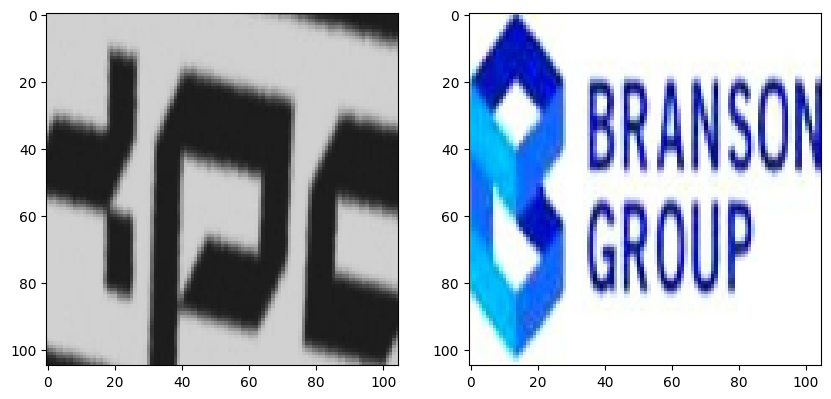

In [113]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()